In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from PIL import Image
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
import random

In [2]:
def load_images_from_folder(folder, label, target_size= (224,224)):
    data = []
    for file_name in os.listdir(folder):
        file_path = os.path.join(folder, file_name)
        try:
            img = Image.open(file_path).convert('RGB')
            img = img.resize(target_size)
            data.append((np.array(img), label))
        except Exception as e:
            print(f"Error loading {file_name}: {e}")
    return data

positive_folder = "positive"
negative_folder = "negative"

positive_images = load_images_from_folder(positive_folder, label=1)
negative_images = load_images_from_folder(negative_folder, label=0)

all_image_data = positive_images + negative_images
random.shuffle(all_image_data)

In [3]:
X = np.array([item[0] for item in all_image_data])
y = np.array([item[1] for item in all_image_data])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train / 255.0
X_test = X_test / 255.0

In [5]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

In [15]:
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\zakir.hussainmuradi\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
epochs = 50
model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.6135 - loss: 3.3079 - val_accuracy: 0.6441 - val_loss: 0.6900
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.7137 - loss: 0.6154 - val_accuracy: 0.7627 - val_loss: 0.5902
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8106 - loss: 0.5107 - val_accuracy: 0.7458 - val_loss: 0.5534
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8008 - loss: 0.4327 - val_accuracy: 0.7288 - val_loss: 0.6108
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8198 - loss: 0.4238 - val_accuracy: 0.7288 - val_loss: 0.5373
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8357 - loss: 0.3893 - val_accuracy: 0.7797 - val_loss: 0.5140
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8492 - loss: 0.3666 - val_accuracy: 0.7966 - val_loss: 0.4724
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8472 - loss: 0.3650 - val_accuracy: 0.6780 - val_loss: 0.5947
Epoch 9/

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


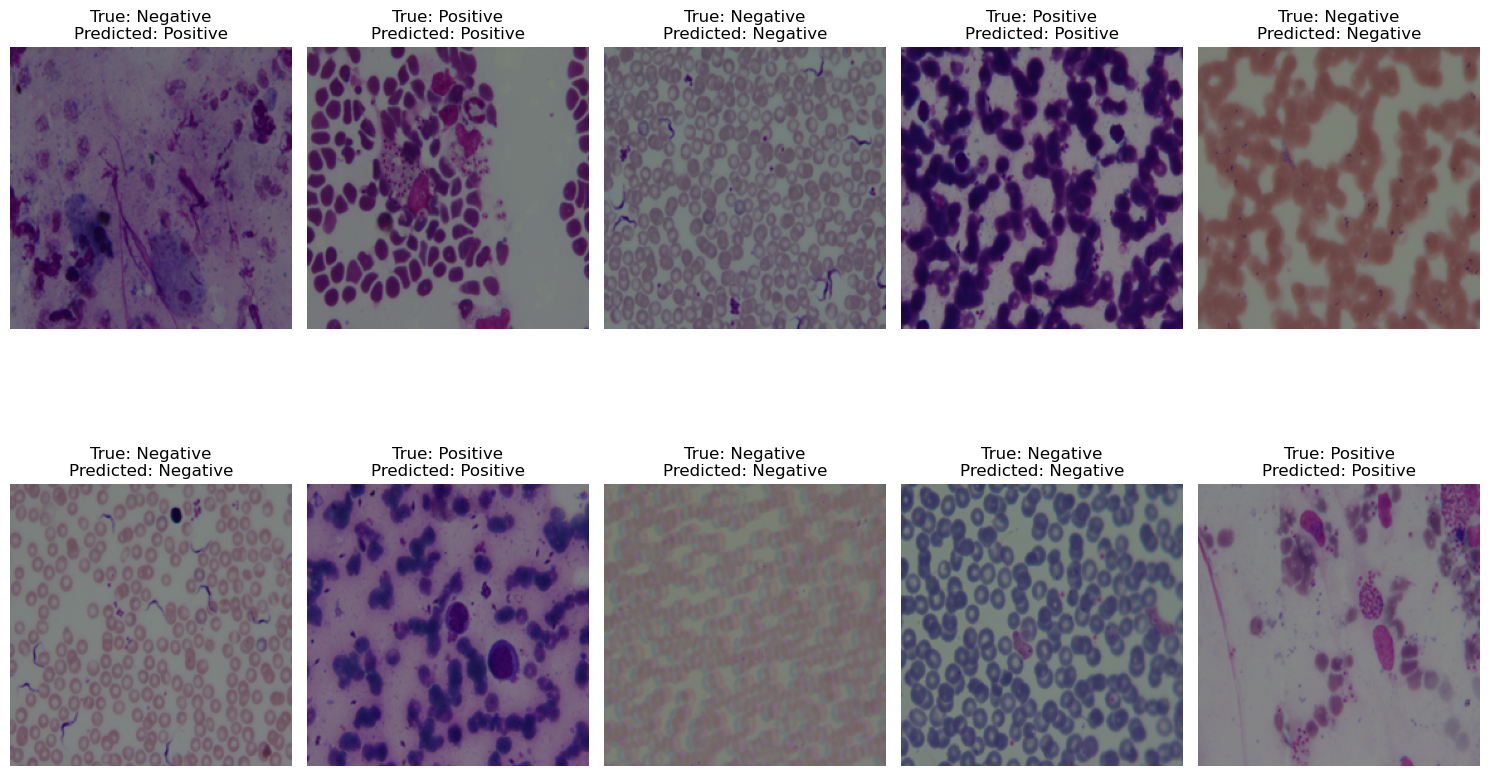

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import random

y_pred = model.predict(test_dataset)
y_pred_classes = (y_pred > 0.5).astype("int32")  

test_images = np.concatenate([x for x, _ in test_dataset])
true_labels = np.concatenate([y for _, y in test_dataset])

if test_images.max() <= 1.0:  
    test_images = (test_images * 255).astype(np.uint8)

def display_random_samples(num_samples=10):
    plt.figure(figsize=(15, 10))
    
    random_indices = random.sample(range(len(test_images)), num_samples)  
    for i, idx in enumerate(random_indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(test_images[idx])
        true_label = "Positive" if true_labels[idx] == 1 else "Negative"
        predicted_label = "Positive" if y_pred_classes[idx] == 1 else "Negative"
        plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

display_random_samples()


In [33]:
model.save("image_classification_with_augmentation.h5")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


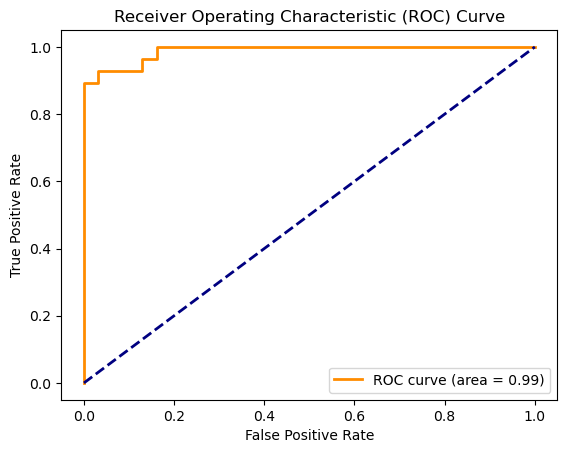

In [37]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_pred_prob = model.predict(test_dataset)
y_pred_classes = (y_pred_prob > 0.5).astype(int) 

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

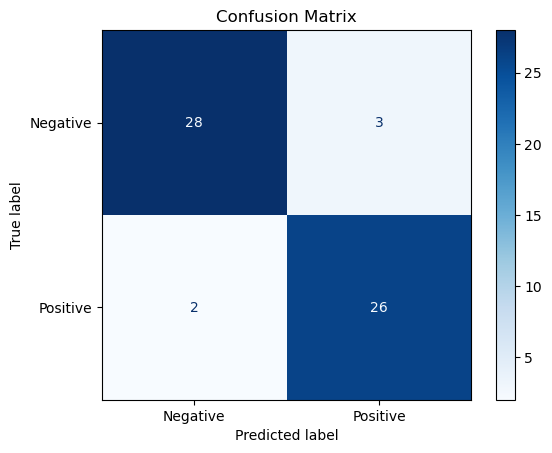

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


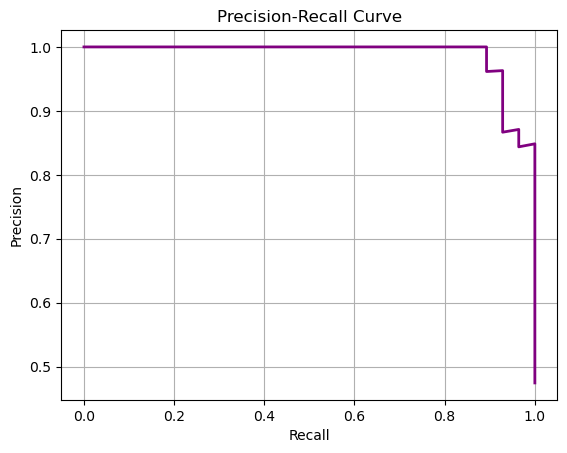

In [43]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

plt.figure()
plt.plot(recall, precision, color='purple', lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid()
plt.show()


Performance Metrics:
Overall Accuracy: 0.92
Precision for Negative: 0.93
Precision for Positive: 0.90
Recall for Negative: 0.90
Recall for Positive: 0.93
F1-score for Negative: 0.92
F1-score for Positive: 0.91


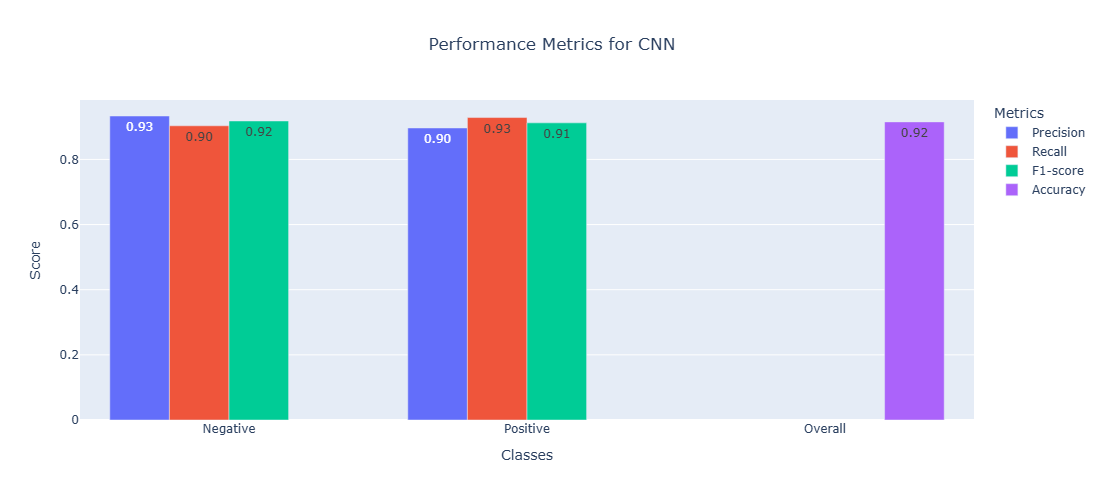

In [65]:
import plotly.graph_objects as go

metrics = ["precision", "recall", "f1-score"]
classes = ["Negative", "Positive"]
values = {metric: [report[cls][metric] for cls in classes] for metric in metrics}
overall_accuracy = report["accuracy"]

print("Performance Metrics:")
print(f"Overall Accuracy: {overall_accuracy:.2f}")
for metric in metrics:
    for cls, value in zip(classes, values[metric]):
        print(f"{metric.capitalize()} for {cls}: {value:.2f}")

fig = go.Figure()

for metric in metrics:
    fig.add_trace(
        go.Bar(
            x=classes,
            y=values[metric],
            name=metric.capitalize(),
            text=[f"{v:.2f}" for v in values[metric]], 
            textposition="auto", 
            hovertemplate=f"{metric.capitalize()}: %{{y:.2f}}"  
        )
    )

fig.add_trace(
    go.Bar(
        x=["Overall"],
        y=[overall_accuracy],
        name="Accuracy",
        text=[f"{overall_accuracy:.2f}"],  
        textposition="auto",  
        hovertemplate="Accuracy: %{y:.2f}"  
    )
)

fig.update_layout(
    title="Performance Metrics for CNN",
    xaxis_title="Classes",
    yaxis_title="Score",
    barmode="group",
    legend_title="Metrics",
    title_x=0.5,
    height=500,
    width=800,
    hovermode="x unified", 
)

fig.show()


In [1]:
import matplotlib.pyplot as plt
from tslearn.shapelets import ShapeletModel, grabocka_params_to_shapelet_size_dict
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tslearn.utils import to_time_series_dataset

In [23]:
def images_to_time_series(image_data):
    time_series = []
    for img in image_data:
        ts = img.mean(axis=2).flatten() 
        time_series.append(ts)
    return np.array(time_series)

X_ts = images_to_time_series(X) 
X_ts = to_time_series_dataset(X_ts)

print("Time series shape:", X_ts.shape) 

Time series shape: (292, 50176, 1)


In [25]:
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=X_train.shape[0],
                                                       ts_sz=X_train.shape[1],
                                                       n_classes=len(np.unique(y)),
                                                       l=0.1,
                                                       r=1)    

model = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                      optimizer="sgd",
                      weight_regularizer=0.01,
                      max_iter=200,
                      verbose=1)

X_ts_train, X_ts_test, y_train_ts, y_test_ts = train_test_split(X_ts, y, test_size=0.2, random_state=42)

model.fit(X_ts_train, y_train_ts)

y_pred_ts = model.predict(X_ts_test)

print("Accuracy:", accuracy_score(y_test_ts, y_pred_ts))
print(classification_report(y_test_ts, y_pred_ts))

C:\Users\zakir.hussainmuradi\AppData\Local\anaconda3\Lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Epoch 1/200


C:\Users\zakir.hussainmuradi\AppData\Local\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_0']. Received: the structure of inputs=('*',)
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - binary_accuracy: 0.6867 - binary_crossentropy: 61.7057 - loss: 61.7191
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - binary_accuracy: 0.7854 - binary_crossentropy: 12.0510 - loss: 12.0574
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - binary_accuracy: 0.4807 - binary_crossentropy: 313.8395 - loss: 313.8467
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - binary_accuracy: 0.5279 - binary_crossentropy: 556.6247 - loss: 557.1494
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - binary_accuracy: 0.5322 - binary_crossentropy: 490.2135 - loss: 490.6334
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - binary_accuracy: 0.5408 - binary_crossentropy: 425.8701 - loss: 426.1982
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - binary_accuracy: 0.5408 - binary_crossentropy: 362.5884 - loss: 362.8375
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - binary_accuracy: 0.5536 - binary_crossentropy: 299.9727 - loss: 300.1554
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━

C:\Users\zakir.hussainmuradi\AppData\Local\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_0']. Received: the structure of inputs=('*',)
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
Accuracy: 0.711864406779661
              precision    recall  f1-score   support

           0       0.86      0.58      0.69        33
           1       0.62      0.88      0.73        26

    accuracy                           0.71        59
   macro avg       0.74      0.73      0.71        59
weighted avg       0.76      0.71      0.71        59



C:\Users\zakir.hussainmuradi\AppData\Local\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_0']. Received: the structure of inputs=('*',)
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━

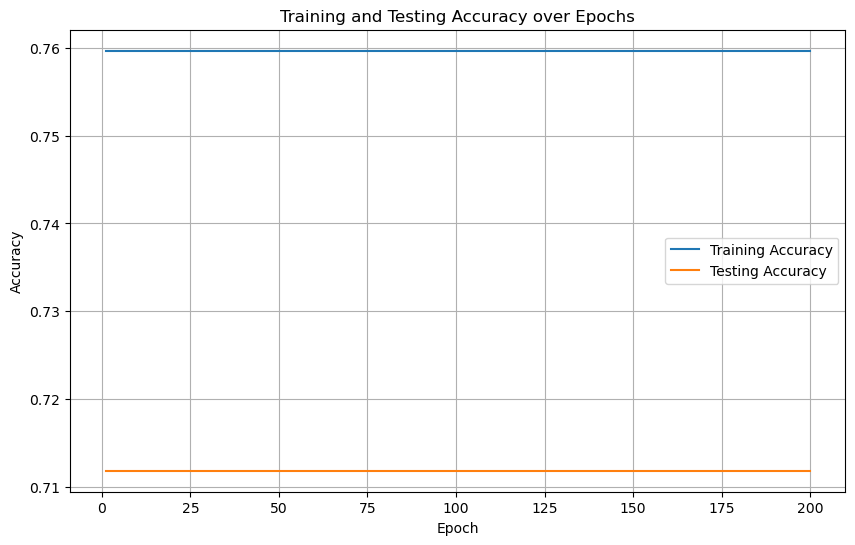

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
Final Accuracy: 0.711864406779661
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.58      0.69        33
           1       0.62      0.88      0.73        26

    accuracy                           0.71        59
   macro avg       0.74      0.73      0.71        59
weighted avg       0.76      0.71      0.71        59



In [27]:
train_accuracies = []
test_accuracies = []

for epoch in range(1, model.n_iter_ + 1):
    train_preds = model.predict(X_ts_train)
    test_preds = model.predict(X_ts_test)
    train_accuracies.append(accuracy_score(y_train_ts, train_preds))
    test_accuracies.append(accuracy_score(y_test_ts, test_preds))

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label="Testing Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Testing Accuracy over Epochs")
plt.legend()
plt.grid()
plt.show()

y_pred_ts = model.predict(X_ts_test)
accuracy = accuracy_score(y_test_ts, y_pred_ts)
classification_rep = classification_report(y_test_ts, y_pred_ts)

print("Final Accuracy:", accuracy)
print("Classification Report:\n", classification_rep)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


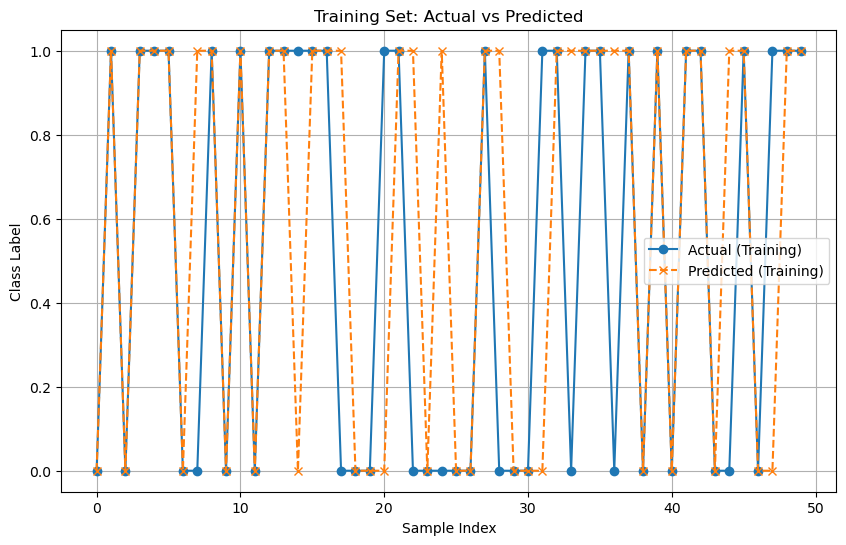

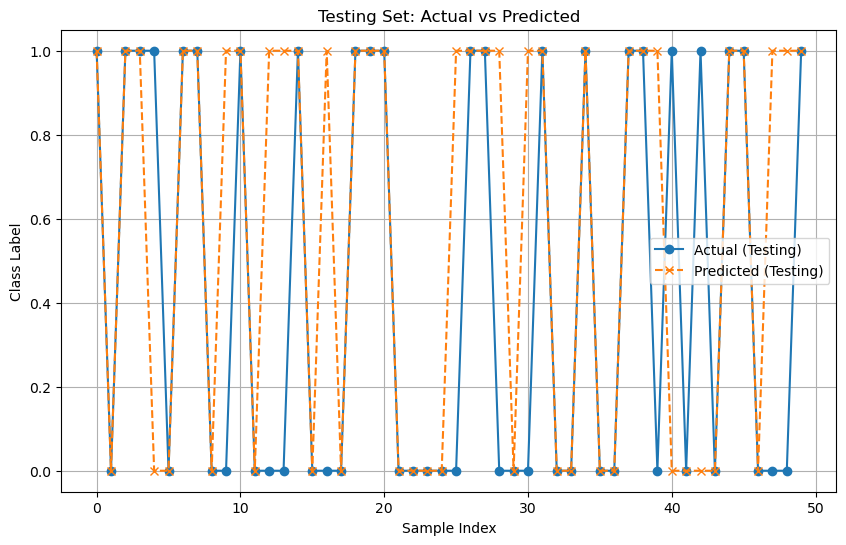

In [45]:
y_train_pred = model.predict(X_ts_train)
y_test_pred = model.predict(X_ts_test)

y_train_pred_binary = [1 if p >= 0.5 else 0 for p in y_train_pred]
y_test_pred_binary = [1 if p >= 0.5 else 0 for p in y_test_pred]

plt.figure(figsize=(10, 6))
plt.plot(y_train_ts[:50], label="Actual (Training)", marker='o', linestyle='-')  # First 50 samples
plt.plot(y_train_pred_binary[:50], label="Predicted (Training)", marker='x', linestyle='--')
plt.title("Training Set: Actual vs Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Class Label")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(y_test_ts[:50], label="Actual (Testing)", marker='o', linestyle='-')  # First 50 samples
plt.plot(y_test_pred_binary[:50], label="Predicted (Testing)", marker='x', linestyle='--')
plt.title("Testing Set: Actual vs Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Class Label")
plt.legend()
plt.grid()
plt.show()

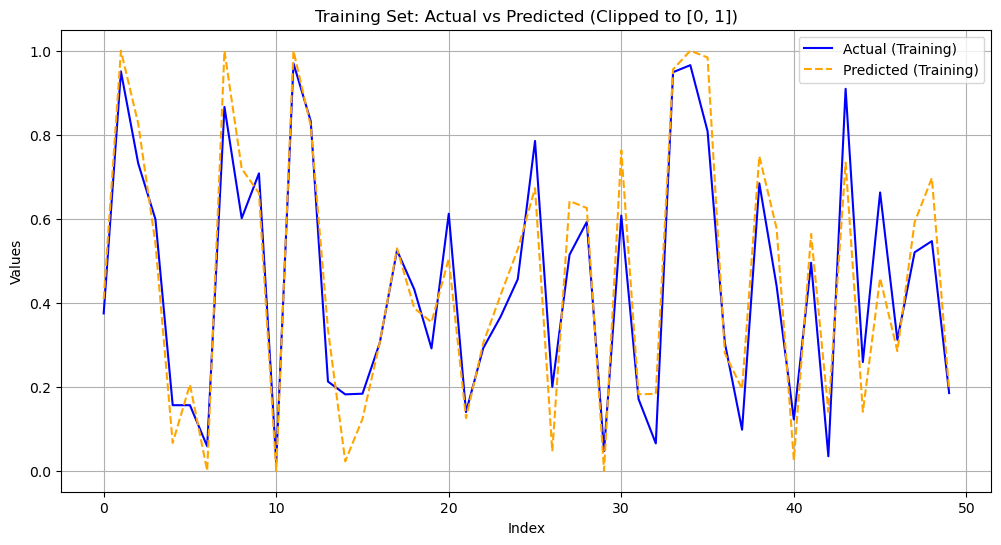

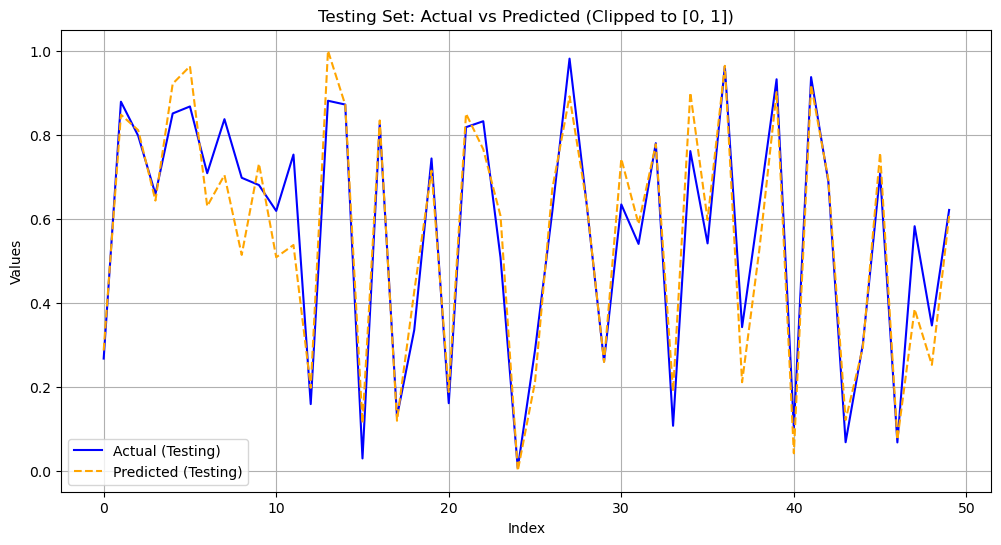

In [49]:
y_train_pred = np.clip(y_train_pred, 0, 1)
y_test_pred = np.clip(y_test_pred, 0, 1)

plt.figure(figsize=(12, 6))
plt.plot(y_train_ts[:50], label="Actual (Training)", color="blue", linestyle="-") 
plt.plot(y_train_pred[:50], label="Predicted (Training)", color="orange", linestyle="--")
plt.title("Training Set: Actual vs Predicted (Clipped to [0, 1])")
plt.xlabel("Index")
plt.ylabel("Values")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test_ts[:50], label="Actual (Testing)", color="blue", linestyle="-")  
plt.plot(y_test_pred[:50], label="Predicted (Testing)", color="orange", linestyle="--")
plt.title("Testing Set: Actual vs Predicted (Clipped to [0, 1])")
plt.xlabel("Index")
plt.ylabel("Values")
plt.legend()
plt.grid()
plt.show()

In [35]:
import pickle

with open("time_series_shapelet.pkl", "wb") as f:
    pickle.dump(model, f)

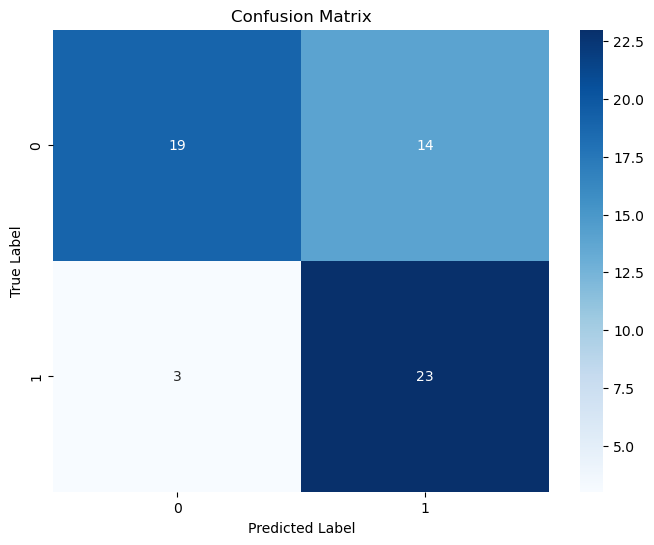

In [43]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, classification_report
import seaborn as sns

conf_matrix = confusion_matrix(y_test_ts, y_pred_ts)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



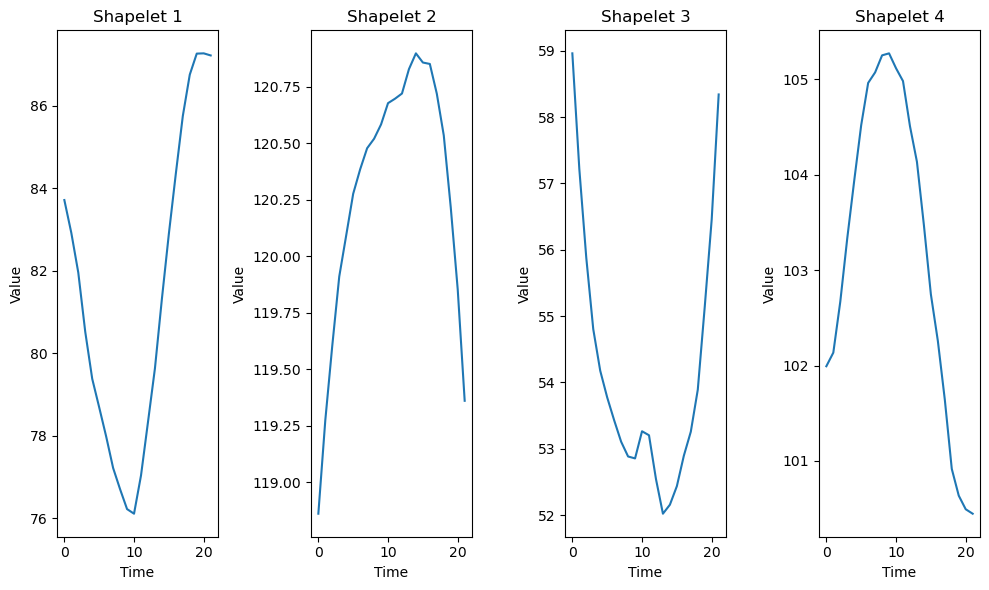

In [37]:
shapelets = model.shapelets_
n_shapelets = len(shapelets)

plt.figure(figsize=(10, 6))
for i, shapelet in enumerate(shapelets):
    plt.subplot(1, n_shapelets, i + 1)
    plt.plot(shapelet)
    plt.title(f"Shapelet {i + 1}")
    plt.xlabel("Time")
    plt.ylabel("Value")
plt.tight_layout()
plt.show()

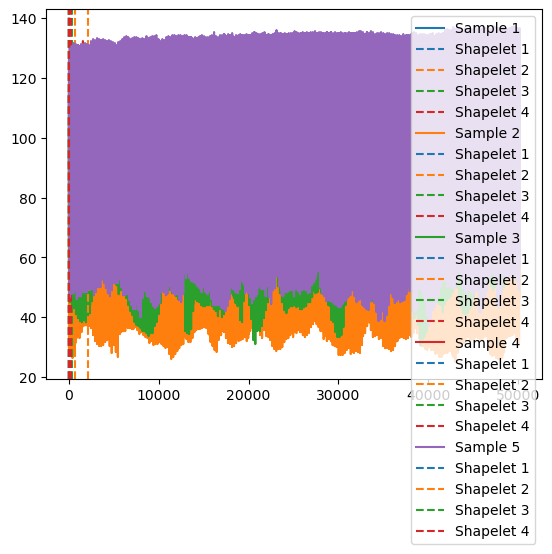

In [69]:
for i in range(5): 
    plt.plot(X_ts_test[i].flatten(), label=f"Sample {i+1}")
    for j, shapelet in enumerate(shapelets):
        pos = transformed[i, j]  
        plt.axvline(x=pos, color=f"C{j}", linestyle="--", label=f"Shapelet {j+1}")
plt.legend()
plt.show()

## Time-Series Transformers

In [122]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt

def load_images_as_time_series(folder, label, target_size=(32, 32)):  
    data = []
    for file_name in os.listdir(folder):
        file_path = os.path.join(folder, file_name)
        try:
            img = Image.open(file_path).convert('RGB')
            img = img.resize(target_size)
            img_array = np.array(img).mean(axis=2).flatten()  # Grayscale and flatten
            data.append((img_array, label))
        except Exception as e:
            print(f"Error loading {file_name}: {e}")
    return data

In [124]:
class PositionalEncoding(layers.Layer):
    def __init__(self, sequence_length, d_model):
        super(PositionalEncoding, self).__init__()
        self.sequence_length = sequence_length
        self.d_model = d_model

        positions = tf.range(start=0, limit=sequence_length, delta=1, dtype=tf.float32)
        indices = tf.range(0, d_model, delta=1, dtype=tf.float32)
        angle_rates = 1 / tf.pow(10000.0, (2 * (indices // 2)) / tf.cast(d_model, tf.float32))
        angles = tf.expand_dims(positions, axis=-1) * tf.expand_dims(angle_rates, axis=0)
        self.positional_encoding = tf.concat([tf.sin(angles), tf.cos(angles)], axis=-1)

    def call(self, x):
        positional_encoding = self.positional_encoding[:self.sequence_length, :self.d_model]
        positional_encoding = tf.expand_dims(positional_encoding, 0)
        positional_encoding = tf.cast(positional_encoding, dtype=tf.float32)
        return x + positional_encoding

class TransformerEncoder(layers.Layer):
    def __init__(self, d_model, num_heads):
        super(TransformerEncoder, self).__init__()
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.norm1 = layers.LayerNormalization()
        self.norm2 = layers.LayerNormalization()
        self.dense1 = layers.Dense(d_model * 2, activation='relu')
        self.dense2 = layers.Dense(d_model)

    def call(self, x):
        attention = self.attention(x, x)
        x = self.norm1(x + attention)
        dense_output = self.dense1(x)
        dense_output = self.dense2(dense_output)
        return self.norm2(x + dense_output)

In [126]:
def create_time_series_transformer(sequence_length, d_model, num_heads, num_layers, num_classes):
    inputs = layers.Input(shape=(sequence_length, 1))
    x = layers.Conv1D(filters=d_model, kernel_size=3, strides=2, padding="same", activation="relu")(inputs)  # Downsample
    x = layers.MaxPooling1D(pool_size=2)(x)  
    x = PositionalEncoding(sequence_length // 4, d_model)(x)
    for _ in range(num_layers):
        x = TransformerEncoder(d_model, num_heads)(x)
    x = layers.GlobalAveragePooling1D()(x)  
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

positive_folder = "positive"
negative_folder = "negative"

positive_data = load_images_as_time_series(positive_folder, label=1, target_size=(32, 32))  
negative_data = load_images_as_time_series(negative_folder, label=0, target_size=(32, 32))

all_data = positive_data + negative_data
np.random.shuffle(all_data)

In [128]:
X = np.array([item[0] for item in all_data])
y = np.array([item[1] for item in all_data])
X = X / 255.0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

sequence_length = X_train.shape[1]  
d_model = 32  
num_heads = 2 
num_layers = 2  
num_classes = 2

ts_transformer_model = create_time_series_transformer(sequence_length, d_model, num_heads, num_layers, num_classes)
ts_transformer_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
ts_transformer_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 1024, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 512, 32)             │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 256, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ positional_encoding_9                │ (None, 256, 32)             │               0 │
│ (PositionalEncoding)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_16               │ (None, 256, 32)             │          12,736 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_17               │ (None, 256, 32)             │          12,736 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,666 (100.26 KB)

 Trainable params: 25,666 (100.26 KB)

 Non-trainable params: 0 (0.00 B)

In [134]:
history = ts_transformer_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.5417 - loss: 0.6858 - val_accuracy: 0.4237 - val_loss: 0.6920
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - accuracy: 0.4493 - loss: 0.6941 - val_accuracy: 0.5932 - val_loss: 0.6866
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.6339 - loss: 0.6820 - val_accuracy: 0.5763 - val_loss: 0.6709
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.5612 - loss: 0.6758 - val_accuracy: 0.4237 - val_loss: 0.7253
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.4814 - loss: 0.7098 - val_accuracy: 0.5763 - val_loss: 0.6697
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.5328 - loss: 0.6940 - val_accuracy: 0.6610 - val_loss: 0.6793
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.5921 - loss: 0.6909 - val_accuracy: 0.6610 - val_loss: 0.6839
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.5909 - loss: 0.6845 - val_accuracy: 0.5763 - val_loss:

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7246 - loss: 0.6369
Test Accuracy: 0.71


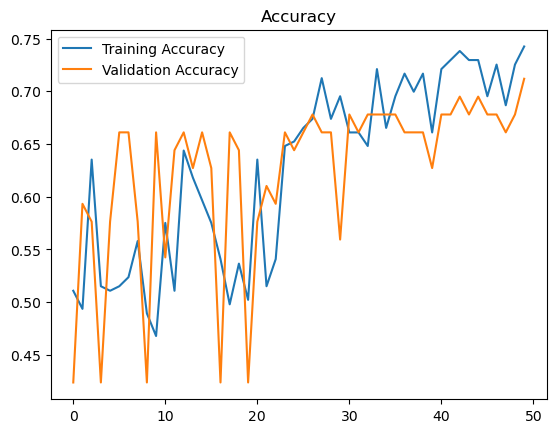

In [136]:
loss, accuracy = ts_transformer_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")
plt.show()

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 900ms/stepWARNING:tensorflow:5 out of the last 14 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000238123F1800> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


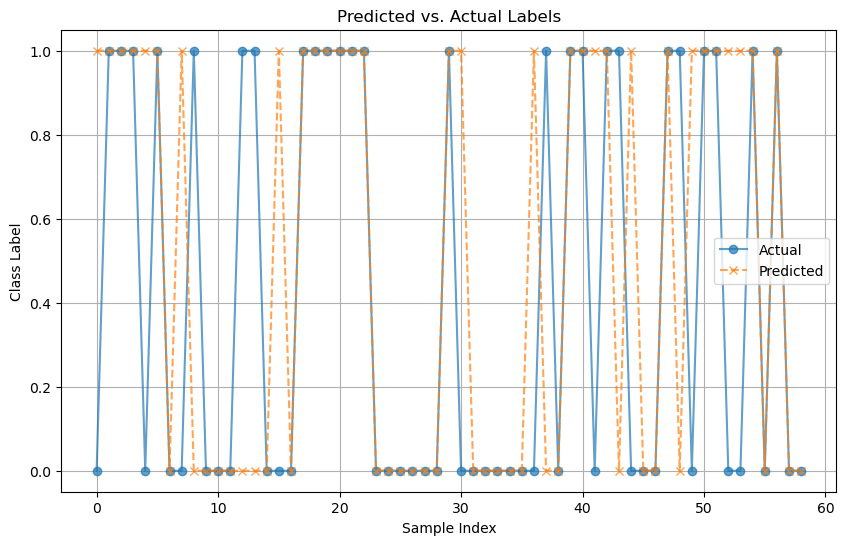

In [138]:

y_pred = ts_transformer_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', linestyle='-', marker='o', alpha=0.7)
plt.plot(y_pred_classes, label='Predicted', linestyle='--', marker='x', alpha=0.7)
plt.title('Predicted vs. Actual Labels')
plt.xlabel('Sample Index')
plt.ylabel('Class Label')
plt.legend()
plt.grid(True)
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


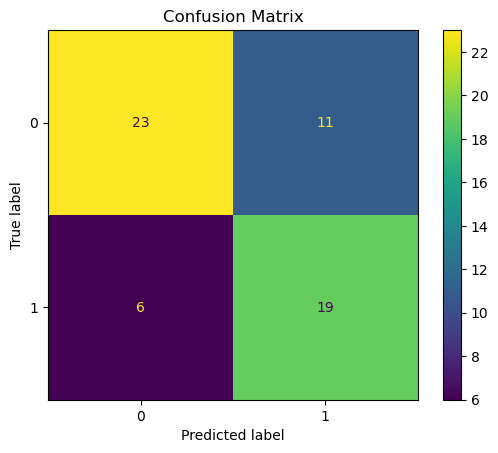

In [140]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = ts_transformer_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 

cm = confusion_matrix(y_test, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix')
plt.show()


In [142]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt

def load_images_as_time_series(folder, label, target_size=(64, 64)):  
    data = []
    for file_name in os.listdir(folder):
        file_path = os.path.join(folder, file_name)
        try:
            img = Image.open(file_path).convert('RGB')
            img = img.resize(target_size)
            img_array = np.array(img).mean(axis=2).flatten() 
            data.append((img_array, label))
        except Exception as e:
            print(f"Error loading {file_name}: {e}")
    return data

In [144]:
class PositionalEncoding(layers.Layer):
    def __init__(self, sequence_length, d_model):
        super(PositionalEncoding, self).__init__()
        self.sequence_length = sequence_length
        self.d_model = d_model

        positions = tf.range(start=0, limit=sequence_length, delta=1, dtype=tf.float32)
        indices = tf.range(0, d_model, delta=1, dtype=tf.float32)
        angle_rates = 1 / tf.pow(10000.0, (2 * (indices // 2)) / tf.cast(d_model, tf.float32))
        angles = tf.expand_dims(positions, axis=-1) * tf.expand_dims(angle_rates, axis=0)
        self.positional_encoding = tf.concat([tf.sin(angles), tf.cos(angles)], axis=-1)

    def call(self, x):
        positional_encoding = self.positional_encoding[:self.sequence_length, :self.d_model]
        positional_encoding = tf.expand_dims(positional_encoding, 0)
        positional_encoding = tf.cast(positional_encoding, dtype=tf.float32)
        return x + positional_encoding

class TransformerEncoder(layers.Layer):
    def __init__(self, d_model, num_heads):
        super(TransformerEncoder, self).__init__()
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.norm1 = layers.LayerNormalization()
        self.norm2 = layers.LayerNormalization()
        self.dense1 = layers.Dense(d_model * 2, activation='relu')
        self.dense2 = layers.Dense(d_model)

    def call(self, x):
        attention = self.attention(x, x)
        x = self.norm1(x + attention)
        dense_output = self.dense1(x)
        dense_output = self.dense2(dense_output)
        return self.norm2(x + dense_output)

In [146]:
def create_time_series_transformer(sequence_length, d_model, num_heads, num_layers, num_classes):
    inputs = layers.Input(shape=(sequence_length, 1))
    x = layers.Conv1D(filters=d_model, kernel_size=3, strides=2, padding="same", activation="relu")(inputs)  # Downsample
    x = layers.MaxPooling1D(pool_size=2)(x)  
    x = PositionalEncoding(sequence_length // 4, d_model)(x)
    for _ in range(num_layers):
        x = TransformerEncoder(d_model, num_heads)(x)
    x = layers.GlobalAveragePooling1D()(x)  
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

positive_folder = "positive"
negative_folder = "negative"

positive_data = load_images_as_time_series(positive_folder, label=1, target_size=(64, 64))  
negative_data = load_images_as_time_series(negative_folder, label=0, target_size=(64, 64))

all_data = positive_data + negative_data
np.random.shuffle(all_data)

In [150]:
X = np.array([item[0] for item in all_data])
y = np.array([item[1] for item in all_data])
X = X / 255.0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

sequence_length = X_train.shape[1]  
d_model = 64  
num_heads = 2 
num_layers = 2  
num_classes = 2

ts_transformer_model = create_time_series_transformer(sequence_length, d_model, num_heads, num_layers, num_classes)
ts_transformer_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
ts_transformer_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 4096, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 2048, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 1024, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ positional_encoding_11               │ (None, 1024, 64)            │               0 │
│ (PositionalEncoding)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_20               │ (None, 1024, 64)            │          50,048 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_21               │ (None, 1024, 64)            │          50,048 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_3           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 100,482 (392.51 KB)

 Trainable params: 100,482 (392.51 KB)

 Non-trainable params: 0 (0.00 B)

In [152]:
history = ts_transformer_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 95s 5s/step - accuracy: 0.5177 - loss: 0.8221 - val_accuracy: 0.5932 - val_loss: 0.6950
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.5309 - loss: 0.7611 - val_accuracy: 0.4068 - val_loss: 0.8427
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.5247 - loss: 0.7362 - val_accuracy: 0.5932 - val_loss: 0.6851
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.4952 - loss: 0.7515 - val_accuracy: 0.4068 - val_loss: 0.7109
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.5038 - loss: 0.6949 - val_accuracy: 0.5932 - val_loss: 0.6759
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.5218 - loss: 0.6909 - val_accuracy: 0.4068 - val_loss: 0.6978
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.5011 - loss: 0.6955 - val_accuracy: 0.5932 - val_loss: 0.6752
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.4964 - loss: 0.7043 - val_accuracy: 0.5932 - val_loss: 0.6889
Epoch 9/

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 679ms/step - accuracy: 0.7255 - loss: 0.5645
Test Accuracy: 0.73


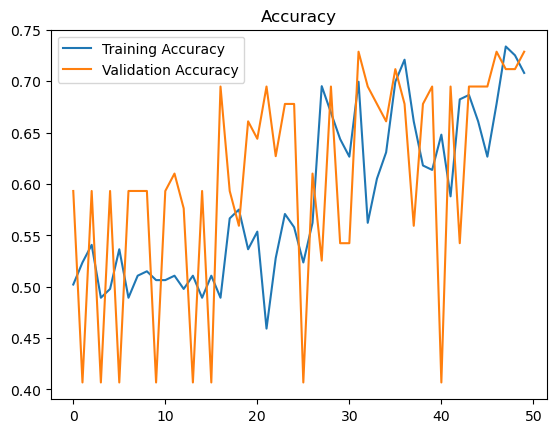

In [154]:
loss, accuracy = ts_transformer_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Accuracy")
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


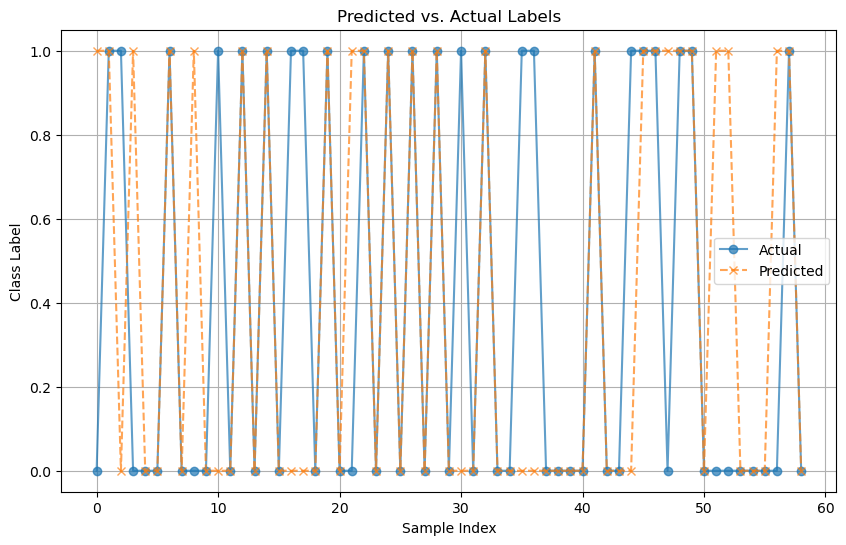

In [156]:

y_pred = ts_transformer_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual', linestyle='-', marker='o', alpha=0.7)
plt.plot(y_pred_classes, label='Predicted', linestyle='--', marker='x', alpha=0.7)
plt.title('Predicted vs. Actual Labels')
plt.xlabel('Sample Index')
plt.ylabel('Class Label')
plt.legend()
plt.grid(True)
plt.show()


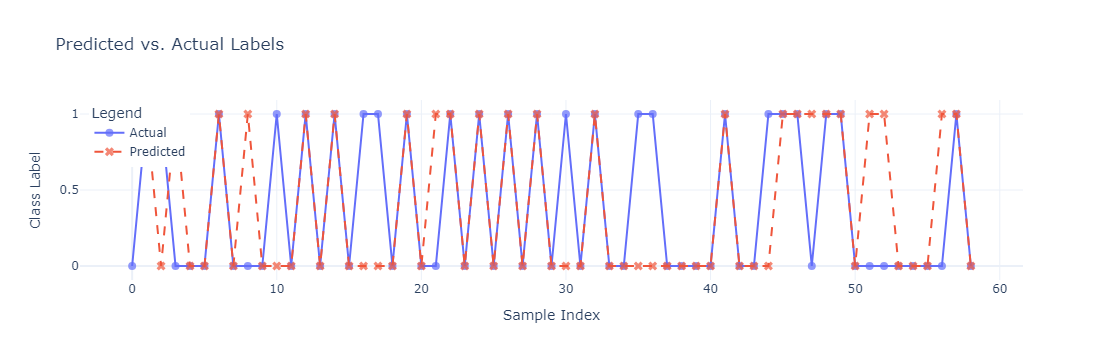

In [166]:
import numpy as np
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=np.arange(len(y_test)),
    y=y_test,
    mode='lines+markers',
    name='Actual',
    line=dict(dash='solid'),
    marker=dict(symbol='circle', size=8, opacity=0.7)
))

fig.add_trace(go.Scatter(
    x=np.arange(len(y_pred_classes)),
    y=y_pred_classes,
    mode='lines+markers',
    name='Predicted',
    line=dict(dash='dash'),
    marker=dict(symbol='x', size=8, opacity=0.7)
))

fig.update_layout(
    title='Predicted vs. Actual Labels',
    xaxis_title='Sample Index',
    yaxis_title='Class Label',
    legend=dict(title='Legend', x=0.01, y=1),
    template='plotly_white'
)

fig.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 719ms/step


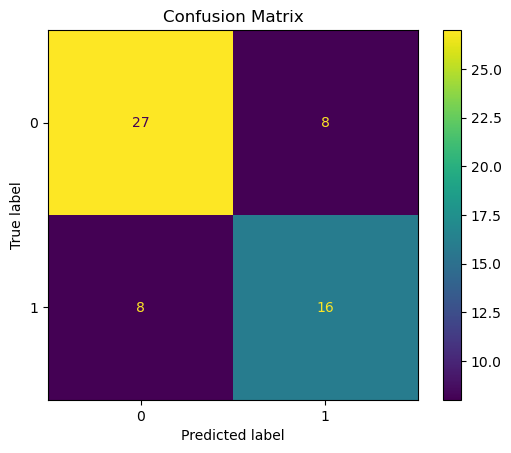

In [158]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = ts_transformer_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 

cm = confusion_matrix(y_test, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [160]:
ts_transformer_model.save("time_series_tranformer.h5")